In [157]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
from statistics import mean
from pandas import DataFrame as df
import matplotlib.pyplot as plt

In [116]:
rho = 0.90
sigma_e_sq = 0.06
w_bar = (-1/2)*(1/(1+rho))*sigma_e_sq

# Problem 1

## 1. Tauchen Method

In [471]:
def preparation(N):
    '''
    input: # of grid point
    output: 1. list of discretized state space (W), in N many spaces --> state_space 
            2. transition matrix (list of list): N number of N sized list --> transition_matrix
    
    '''
    w_max = 3*((sigma_e_sq/(1-(rho**2)))**(1/2)) + w_bar/(1-rho)
    w_min = 2*(w_bar/(1-rho)) - w_max
    d = (w_max - w_min)/(N-1)
    state_space = [w_min + i*d for i in range(N)]
    
    transition_matrix = []
    rv = norm()
    for j in range(N):    
        temp = []
        for k in range(N):
            if k == 0:
                prob = rv.cdf((state_space[k] + d/2 - w_bar - rho*state_space[j])/(sigma_e_sq**(1/2))) 
            elif k == N-1:
                prob = 1 - rv.cdf((state_space[k] - d/2 - w_bar - rho*state_space[j])/(sigma_e_sq**(1/2)))    
            else:
                prob = ( rv.cdf((state_space[k] + d/2 - w_bar - rho*state_space[j])/(sigma_e_sq**(1/2))) 
                        -rv.cdf((state_space[k] - d/2 - w_bar - rho*state_space[j])/(sigma_e_sq**(1/2))) )   
            temp.append(prob)
        transition_matrix.append(temp)

    return state_space, transition_matrix

In [371]:
'''
def stationary_distribution(transition_matrix):
    epsilon = 0.0000000000000001
    size = len(transition_matrix)
    initial_dist = np.array([1/size for i in range(size)])
    while True:
        post_dist = initial_dist @ transition_matrix
        if np.dot(post_dist-initial_dist, post_dist-initial_dist) < epsilon:
            break
        else:
            initial_dist = post_dist
            
    return post_dist

In [477]:
def simulation(state_space, transition_matrix, iteration_num):
    '''
    input: state_space, transition_matrix, iteration_num
    output: simulated process of W and Y, process of true Y
    '''
    # 1. stationary distribution derive
    size = len(transition_matrix)
    stationary_dist = np.array([1/size for i in range(size)])

    # 2. choose initial state randomly using stationary distribution
    pre_state = np.random.choice(state_space, 1, list(stationary_dist))[0]
    pre_state_index = state_space.index(pre_state)
    pre_true_w = pre_state
    
    process_W = [pre_state]
    process_Y = [math.exp(pre_state)]
    process_true_W = [pre_state]
    process_true_Y = [math.exp(pre_state)]
    
    for i in range(iteration_num):
        post_state = np.random.choice(state_space, 1, list(transition_matrix[pre_state_index]))[0]
        post_state_index = state_space.index(post_state)
        process_W.append(post_state)
        process_Y.append(math.exp(post_state))
        pre_state_index = post_state_index
        
        e = np.random.normal(0, sigma_e_sq**(1/2), 1)[0]
        process_true_W.append(w_bar + rho*pre_true_w + e)
        process_true_Y.append(math.exp(w_bar + rho*pre_true_w + e))
        pre_true_w = w_bar + rho*pre_true_w + e

    return process_W, process_Y, process_true_Y

## (a) 5 State Tauchen Method

In [478]:
# do 1000 different simulations 
# each simulation has a process with length 10000
state_space_5, transition_matrix_5 = preparation(5)
mean_disc_y = []
mean_true_y = []
for i in range(1000):
    process_w, process_y, process_true_y = simulation(state_space_5, transition_matrix_5, 10000)
    mean_disc_y.append(mean(process_y))
    mean_true_y.append(mean(process_true_y))    

In [479]:
print("average income under 5 state tauchen: ", mean(mean_disc_y))
print("average true income : ", mean(mean_true_y))
print("tauchen / true : ", mean(mean_disc_y)/mean(mean_true_y))

average income under 5 state tauchen:  1.5940741468345587
average true income :  0.9992102144211746
tauchen / true :  1.595334118714928


## (b) 11 State Tauchen Method

In [480]:
# do 1000 different simulations 
# each simulation has a process with length 10000
state_space_11, transition_matrix_11 = preparation(11)
mean_disc_y2 = []
mean_true_y2 = []
for i in range(1000):
    process_w, process_y, process_true_y = simulation(state_space_11, transition_matrix_11, 10000)
    mean_disc_y2.append(mean(process_y))
    mean_true_y2.append(mean(process_true_y))    

In [481]:
print("average income under 11 state tauchen: ", mean(mean_disc_y2))
print("average true income : ", mean(mean_true_y2))
print("tauchen / true : ", mean(mean_disc_y2)/mean(mean_true_y2))

average income under 11 state tauchen:  1.4275867027104374
average true income :  1.0009172035442178
tauchen / true :  1.4262785150014365


<pre>
under the 11 states, tauchen method better approxmiates the true process
</pre>

## Cf) Experiment for intuition
### with a same fixed initial condition

In [238]:
state_space_5, transition_matrix_5 = preparation(5)
state_space_11, transition_matrix_11 = preparation(11)
state_space_101, transition_matrix_101 = preparation(101)

W_s5,Y_s5, Y_true = simulation(state_space_5, transition_matrix_5, 100)
W_s11,Y_s11, Y_true2 = simulation(state_space_11, transition_matrix_11, 100)
W_s101,Y_s101, Y_true3 = simulation(state_space_101, transition_matrix_101, 100)

In [180]:
data = {'Y_s5'  : Y_s5,
        'Y_s11' : Y_s11,
        'Y_s101' : Y_s101,
        'Y_true': Y_true}
simulated_data = df(data)

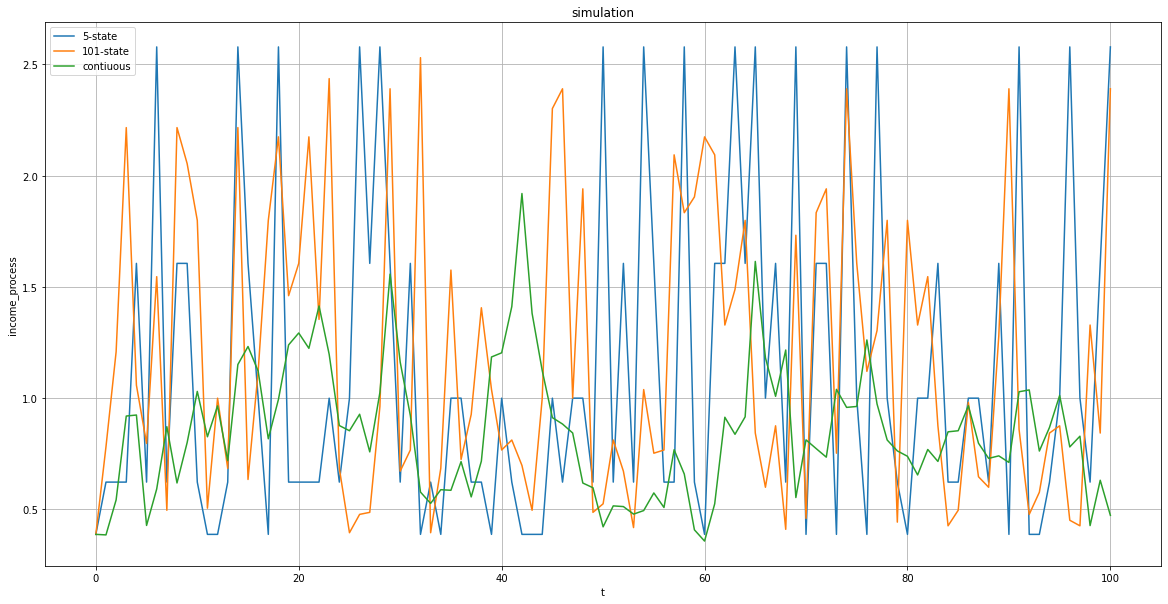

In [185]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xlabel('t')
ax.set_ylabel('income_process')
ax.set_title('simulation')
ax.grid(True)

ax.plot(simulated_data.Y_s5, label = '5-state')
#ax.plot(simulated_data.Y_s11, label = '11-state')
ax.plot(simulated_data.Y_s101, label = '101-state')
ax.plot(simulated_data.Y_true, label = 'contiuous')
ax.legend(loc='upper left');


## 2. Rouwenhorst Method

### (c) Rouwenhorst performs better than Tauchen

In [430]:
def Rouwenhorst_Transition(p, q, N):
    pre = np.array([
        [p, 1-p],
        [1-q, q]
        ])
    for i in range(N-2):
        ul = np.c_[pre, np.zeros(i+2)]
        ul = np.r_[ul,[np.zeros(i+3)]]
        ur = np.c_[np.zeros(i+2), pre]
        ur = np.r_[ur,[np.zeros(i+3)]]
        ll = np.c_[pre, np.zeros(i+2)]
        ll = np.r_[[np.zeros(i+3)], ll]
        lr = np.c_[np.zeros(i+2), pre]
        lr = np.r_[[np.zeros(i+3)], lr]
        pre = p*ul + (1-p)*ur + (1-q)*ll + q*lr
        matrix_size = len(pre)
        for j in range(matrix_size-2):
            pre[j+1] = (1/2) * pre[j+1]
    return pre

In [482]:
def Rouwenhorst_Space(psi, N):
    space = np.linspace(-psi + w_bar/(1-rho), psi + w_bar/(1-rho), N)
    return list(space)

In [483]:
N = 5
sigma_w_sq = sigma_e_sq/(1-rho**2)
p = (1+rho)/2
q = (1+rho)/2
psi = ((N-1)**(1/2))*(sigma_w_sq**(1/2)) 

In [486]:
rouwen_space = Rouwenhorst_Space(psi, 5)
rouwen_transition = Rouwenhorst_Transition(p,q,5)
mean_disc_y3 = []
mean_true_y3 = []
for i in range(1000):
    rouwen_w, rouwen_y, rouwen_true_y = simulation(rouwen_space, rouwen_transition, 10000)
    mean_disc_y3.append(mean(rouwen_y))
    mean_true_y3.append(mean(rouwen_true_y))

In [487]:
print("average income under 5 state rouwen: ", mean(mean_disc_y3))
print("average true income : ", mean(mean_true_y3))
print("rouwen / true : ", mean(mean_disc_y3)/mean(mean_true_y3))

average income under 5 state rouwen:  1.1483166250591983
average true income :  0.9998422553832027
rouwen / true :  1.148497794403669


In [488]:
rouwen_space = Rouwenhorst_Space(psi, 30)
rouwen_transition = Rouwenhorst_Transition(p,q,30)
mean_disc_y3 = []
mean_true_y3 = []
for i in range(1000):
    rouwen_w, rouwen_y, rouwen_true_y = simulation(rouwen_space, rouwen_transition, 10000)
    mean_disc_y3.append(mean(rouwen_y))
    mean_true_y3.append(mean(rouwen_true_y))

In [489]:
print("average income under 30 state rouwen: ", mean(mean_disc_y3))
print("average true income : ", mean(mean_true_y3))
print("rouwen / true : ", mean(mean_disc_y3)/mean(mean_true_y3))

average income under 30 state rouwen:  1.0596047937613156
average true income :  1.0015424951124328
rouwen / true :  1.0579728757713518


### (d)

In [850]:
N = 5
rho = 0.98
sigma_e_sq2 = ((1-((0.98)**2))/(1-((0.9)**2)))*sigma_e_sq
sigma_w_sq = sigma_e_sq2/(1-rho**2)
p = (1+rho)/2
q = (1+rho)/2
psi = ((N-1)**(1/2))*(sigma_w_sq**(1/2)) 

In [857]:
rouwen_space2 = Rouwenhorst_Space(psi, 5)
rouwen_transition2 = Rouwenhorst_Transition(p,q,5)
mean_disc_y4 = []
mean_true_y4 = []
for i in range(1000):
    rouwen_w, rouwen_y, rouwen_true_y = simulation(rouwen_space2, rouwen_transition2, 10000)
    mean_disc_y4.append(mean(rouwen_y))
    mean_true_y4.append(mean(rouwen_true_y))

In [858]:
print("average income under 5 state rouwen: ", mean(mean_disc_y4))
print("average true income : ", mean(mean_true_y4))
print("rouwen / true : ", mean(mean_disc_y4)/mean(mean_true_y4))

average income under 5 state rouwen:  0.6110219993837215
average true income :  0.97791379330765
rouwen / true :  0.6248219460296486


# Problem 2

### (A)-1 Discretization

In [731]:
# use the derived income process in 1-(c)
rouwen_space = Rouwenhorst_Space(psi, 5)
rouwen_transition = Rouwenhorst_Transition(p,q,5)

disc_y = [math.exp(i) for i in rouwen_space]
transition_y = rouwen_transition

In [732]:
# set the parameter
gamma = 2
beta = 0.95
r = 0.02
R = 1+r
pi = 0

In [754]:
# Step 1: Diescretize the a space
a_min = pi
a_max = 50  ## what is a reasonable max value? 
state_num = 100
disc_a = [a_min + (a_max-a_min)*((i/(state_num-1))**2) for i in range(state_num)]

In [734]:
# Step 2: Guess an initial rule for a''
initial_rule = []
for a in disc_a:
    temp = []
    for y in disc_y:
        temp.append(a)
    initial_rule.append(temp) 

In [826]:
# i: state for asset
# j: state for income
def delta(i,j,i_prime, gamma):
    EE_LHS = (R*disc_a[i] + disc_y[j] - disc_a[i_prime])**(-gamma)
    temp_RHS = 0
    y_state_num = len(disc_y)
    for k in range(y_state_num):
            temp_RHS += transition_y[j][k] * ((R*disc_a[i_prime] + disc_y[k] - initial_rule[i_prime][k])**(-gamma))    
    EE_RHS = beta*R*temp_RHS
    return EE_LHS - EE_RHS

In [517]:
# Step 3 & 4: Update Logic
y_state_num = 5 # y discretized number
post_rule = []
for i in range(len(disc_a)):
    temp_rule = []

    for j in range(len(disc_y)):
        EE_LHS = (R*disc_a[i]+disc_y[j]-disc_a[0])**(-2)
        temp_RHS = 0
        for k in range(y_state_num):
            temp_RHS += transition_y[j][k] * ((R*disc_a[0] + disc_y[k] - initial_rule[0][k])**(-2))    
        EE_RHS = beta*R*temp_RHS
        
        if EE_LHS > EE_RHS:
            temp_rule.append(disc_a[0])
        else:
            # find l s.t delta(l) < 0 and delta(l) > 0 
            for l in range(len(disc_a)-1):
                if delta(i,j,l) < 0 and delta(i,j,l+1) > 0:
                    break
            # update interior saving rule
            if abs(delta(i,j,l)) < abs(delta(i,j,l+1)):
                temp_rule.append(disc_a[l])
            else:
                temp_rule.append(disc_a[l+1])
                
    post_rule.append(temp_rule)

In [755]:
# Iterate !!
initial_rule = []
for a in disc_a:
    temp = []
    for y in disc_y:
        temp.append(a)
    initial_rule.append(temp)
    
while True: 
    y_state_num = 5 # y discretized number
    post_rule = []
    for i in range(len(disc_a)):
        temp_rule = []

        for j in range(len(disc_y)):
            EE_LHS = (R*disc_a[i]+disc_y[j]-disc_a[0])**(-2)
            temp_RHS = 0
            for k in range(y_state_num):
                temp_RHS += transition_y[j][k] * ((R*disc_a[0] + disc_y[k] - initial_rule[0][k])**(-2))    
            EE_RHS = beta*R*temp_RHS

            if EE_LHS > EE_RHS:
                temp_rule.append(disc_a[0])
            else:
                # find l s.t delta(l) < 0 and delta(l) > 0 
                for l in range(len(disc_a)-1):
                    if delta(i,j,l) < 0 and delta(i,j,l+1) > 0:
                        break
                # update interior saving rule
                if abs(delta(i,j,l)) < abs(delta(i,j,l+1)):
                    temp_rule.append(disc_a[l])
                else:
                    temp_rule.append(disc_a[l+1])
        post_rule.append(temp_rule)
    
    if abs(np.array(initial_rule) - np.array(post_rule)).max() < 0.000001:
        break
    else:
        initial_rule = post_rule

In [756]:
saving_rule_discretization = initial_rule

### (A)-2 Endogenous Grid Method

In [618]:
# use the derived income process in 1-(c)
rouwen_space = Rouwenhorst_Space(psi, 5)
rouwen_transition = Rouwenhorst_Transition(p,q,5)

disc_y = [math.exp(i) for i in rouwen_space]
transition_y = rouwen_transition

In [620]:
# set the parameter
gamma = 2
beta = 0.95
r = 0.02
R = 1+r
pi = 0

In [757]:
# Step 2: Guess an initial rule for Consumption
# 5 X 50 i.e, income by asset matrix
consume_policy = []

for y in disc_y:
    temp = []
    for a in disc_a:
        temp.append(r*a+y)
    consume_policy.append(temp)

In [674]:
def RHS_B(i_prime, j, consume_policy):
    '''
    i_prime: index for tmr's asset state
    j: index for today's income
    '''
    temp_RHS = 0
    y_state_num = len(disc_y)
    for k in range(y_state_num):
            temp_RHS += transition_y[j][k] * ((consume_policy[k][i_prime])**(-gamma))    
    RHS_B = beta*R*temp_RHS
    return RHS_B

def close_index_finder(i_prime, a_star_list):
    init_value = 10
    init_index = 0 
    left_length = 0
    right_length = 0
    
    for l in range(len(a_star_list)-1):
        left = abs(a_star_list[l] - disc_a[i_prime])
        right = abs(a_star_list[l+1] - disc_a[i_prime])
        measure = left+right
        if measure < init_value:
            init_value = measure
            init_index = l
            left_length = left
            right_length = right
    return init_index, left_length, right_length

In [765]:
# try iterate
consume_policy = []
for y in disc_y:
    temp = []
    for a in disc_a:
        temp.append(r*a+y)
    consume_policy.append(temp)
    
while True:
    y_state_num = len(disc_y)
    post_rule = []
    for j in range(y_state_num):
        edgs_grid = []
        edgs_consumption = []
        for a in disc_a:
            a_index = disc_a.index(a)
            B_ij = RHS_B(a_index, j, consume_policy)
            c_tilda = B_ij**(-1/gamma)
            a_star = (1/R)*(c_tilda + a - disc_y[j]) 
            edgs_grid.append(a_star)
            edgs_consumption.append(c_tilda)

        temp_updated_rule = [] # disc_y[j] 에 대해서 일시적으로 업데이트 해준 리스트
        for a_index in range(len(disc_a)):
            if disc_a[a_index] < edgs_grid[0]:
                temp_updated_rule.append(R*disc_a[a_index] + disc_y[j] - disc_a[0])
            else:
                l, left, right = close_index_finder(a_index, edgs_grid)
                norm = left+right
                left_consume = edgs_consumption[l]
                right_consume = edgs_consumption[l+1]
                updated_consume = (left/norm)*left_consume + (right/norm)*right_consume
                temp_updated_rule.append(updated_consume)
                #temp_updated_rule.append(left_consume)
                
        post_rule.append(temp_updated_rule)

    if abs(np.array(consume_policy) - np.array(post_rule)).max() < 0.035:
        break
    else:
        consume_policy = post_rule

In [766]:
consuming_rule_edgs = consume_policy

### (B) Simulation

#### 1. Construct a Income Process

In [812]:
# 1. Draw T = 1000 to visualize
alpha = list(np.random.uniform(low=0.0, high=1.0, size=5000))

rouwen_space = Rouwenhorst_Space(psi, 5)
rouwen_transition = Rouwenhorst_Transition(p,q,5)

disc_y = [math.exp(i) for i in rouwen_space]
transition_y = rouwen_transition

In [813]:
# 2. Start with the lowest income
income_process_index = [0]
income_process_value = [disc_y[0]]

In [814]:
# 3. Generate Income Process
# income_process_value includes generated income process
for index in range(len(alpha)):
    transition_index = income_process_index[index]
    transition = transition_y[transition_index]
    
    seed = alpha[index]
   
    if seed < transition[0]:
        income_process_index.append(0)
        income_process_value.append(disc_y[0])
    elif seed < transition[0] + transition[1]:
        income_process_index.append(1)
        income_process_value.append(disc_y[1])
    elif seed < transition[0] + transition[1] + transition[2]:
        income_process_index.append(2)
        income_process_value.append(disc_y[2])
    elif seed < transition[0] + transition[1] + transition[2] + transition[3]:
        income_process_index.append(3)
        income_process_value.append(disc_y[3])
    else:
        income_process_index.append(4)
        income_process_value.append(disc_y[4])

#### 2. (a) Simulate Using Discretized Result

In [784]:
def find_nearest(saving):
    array = np.array(disc_a)
    idx = (np.abs(array - saving)).argmin()
    return disc_a.index(array[idx])

In [815]:
# 4. Generate Consumption and Asset Holding

asset_state_value = [disc_a[1]]
asset_state_index = [1]
consume_dscrt = []

for i in range(len(income_process_index)):
    
    saving = saving_rule_discretization[asset_state_index[i]][income_process_index[i]]
    consumption = income_process_value[i] + R*asset_state_value[i] - saving
    saving_index = find_nearest(saving)

    asset_state_index.append(saving_index)
    consume_dscrt.append(consumption)
    asset_state_value.append(disc_a[saving_index])

saving_dscrt = asset_state_value[1:]

In [816]:
data = {'income_process'  : income_process_value,
        'consumption' : consume_dscrt,
        'saving' : saving_dscrt,}
consumption_data = df(data)

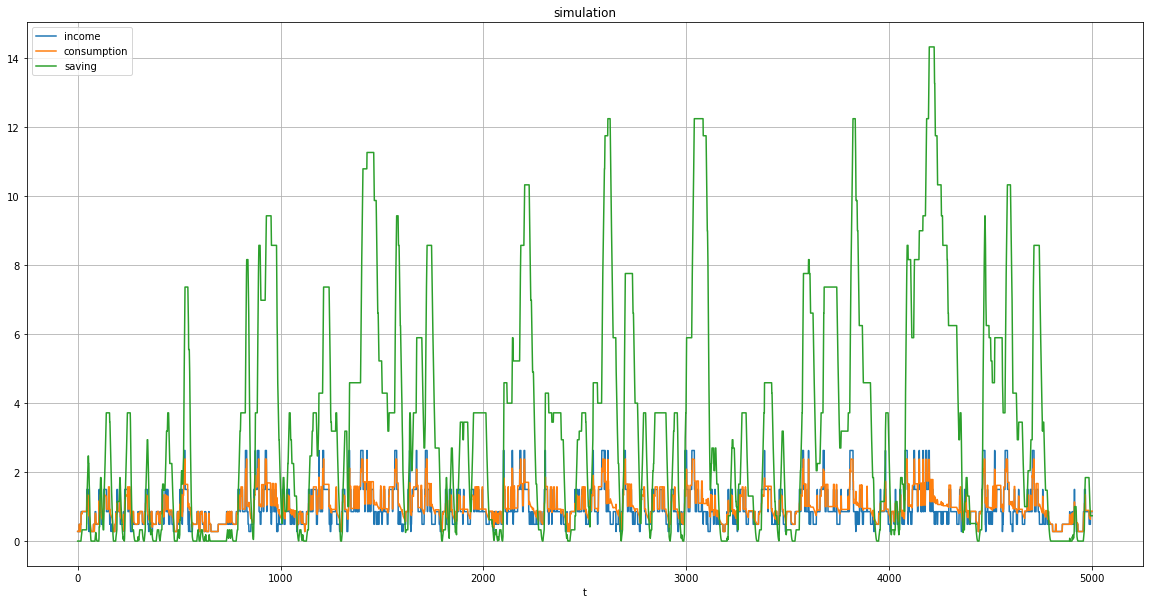

In [817]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xlabel('t')
ax.set_title('simulation')
ax.grid(True)

ax.plot(consumption_data.income_process, label = 'income')
ax.plot(consumption_data.consumption, label = 'consumption')
ax.plot(consumption_data.saving, label = 'saving')
ax.legend(loc='upper left');

### (C) put different gamma and check std.deviation for consumption for each case

In [831]:
def question_3(gamma):

    initial_rule = []
    for a in disc_a:
        temp = []
        for y in disc_y:
            temp.append(a)
        initial_rule.append(temp)

    while True: 
        y_state_num = 5 # y discretized number
        post_rule = []
        for i in range(len(disc_a)):
            temp_rule = []

            for j in range(len(disc_y)):
                EE_LHS = (R*disc_a[i]+disc_y[j]-disc_a[0])**(-gamma)
                temp_RHS = 0
                for k in range(y_state_num):
                    temp_RHS += transition_y[j][k] * ((R*disc_a[0] + disc_y[k] - initial_rule[0][k])**(-gamma))    
                EE_RHS = beta*R*temp_RHS

                if EE_LHS > EE_RHS:
                    temp_rule.append(disc_a[0])
                else:
                    # find l s.t delta(l) < 0 and delta(l) > 0 
                    for l in range(len(disc_a)-1):
                        if delta(i,j,l, gamma) < 0 and delta(i,j,l+1, gamma) > 0:
                            break
                    # update interior saving rule
                    if abs(delta(i,j,l, gamma)) < abs(delta(i,j,l+1, gamma)):
                        temp_rule.append(disc_a[l])
                    else:
                        temp_rule.append(disc_a[l+1])
            post_rule.append(temp_rule)

        if abs(np.array(initial_rule) - np.array(post_rule)).max() < 0.000001:
            break
        else:
            initial_rule = post_rule
            
    return initial_rule

In [832]:
gamma1 = question_3(1)
gamma2 = question_3(2)
gamma5 = question_3(5)

In [837]:
def simulator_q3(saving_rule_discretization):
    asset_state_value = [disc_a[1]]
    asset_state_index = [1]
    consume_dscrt = []

    for i in range(len(income_process_index)):

        saving = saving_rule_discretization[asset_state_index[i]][income_process_index[i]]
        consumption = income_process_value[i] + R*asset_state_value[i] - saving
        saving_index = find_nearest(saving)

        asset_state_index.append(saving_index)
        consume_dscrt.append(consumption)
        asset_state_value.append(disc_a[saving_index])

    saving_dscrt = asset_state_value[1:]
    
    return consume_dscrt

In [841]:
consume1 = simulator_q3(gamma1) 
consume2 = simulator_q3(gamma2)
consume5 = simulator_q3(gamma5)

std1 = np.std(np.array(consume1))
std2 = np.std(np.array(consume2))
std5 = np.std(np.array(consume5))

In [842]:
print("consumption std.dev under gamma = 1 :", std1)
print("consumption std.dev under gamma = 2 :", std2)
print("consumption std.dev under gamma = 5 :", std5)

consumption std.dev under gamma = 1 : 0.4477920808469072
consumption std.dev under gamma = 2 : 0.4453467208062468
consumption std.dev under gamma = 5 : 0.4263727416600025


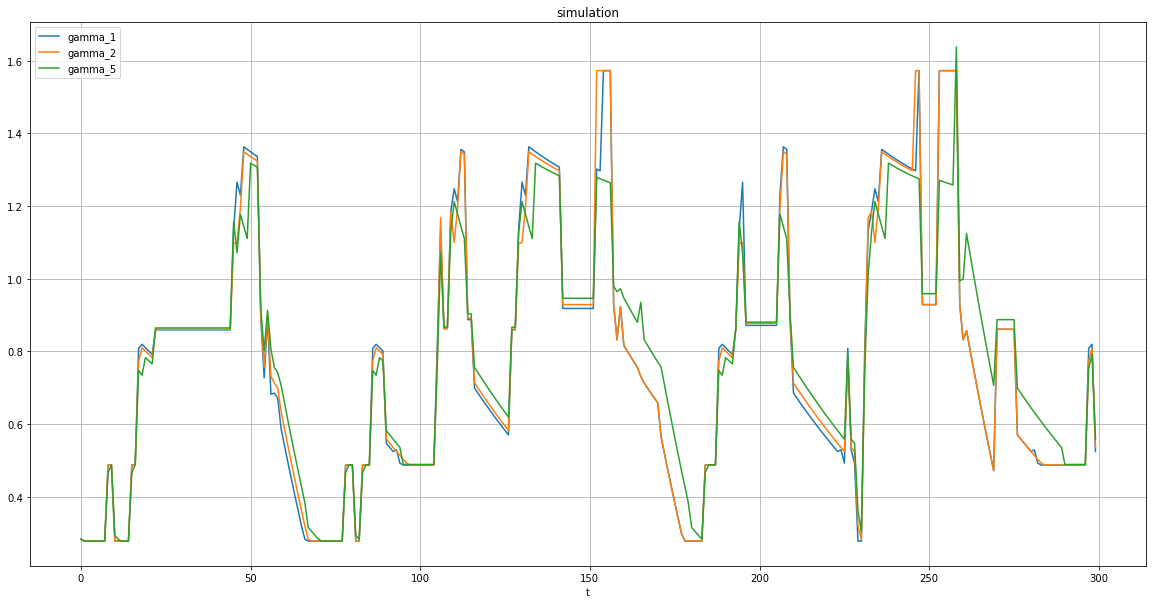

In [845]:
data = {'gamma_1' : consume1,
        'gamma_2' : consume2,
        'gamma_5' : consume5,}
consumption_data = df(data)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xlabel('t')
ax.set_title('simulation')
ax.grid(True)

consumption_data = consumption_data[:300]

ax.plot(consumption_data.gamma_1, label = 'gamma_1')
ax.plot(consumption_data.gamma_2, label = 'gamma_2')
ax.plot(consumption_data.gamma_5, label = 'gamma_5')
ax.legend(loc='upper left');

#### as gamma increases, standard deviation of consumption decreases